# EDA and Feature Engineering Notebook

In [176]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('all_data.csv')
df.head()

,company_name,departure_time,pickup_point,arrival_time,dropoff_point,price_original,price_discounted,departure_date,start_point,destination,...,rating_info_accuracy,rating_info_completeness,rating_staff_attitude,rating_comfort,rating_service_quality,rating_punctuality,rating_overall,reviewer_count,number_of_seat,duration_minutes
0,Hoàng Thuỷ,18:45:00,Bến xe,05:45,Bến xe,350000,300000,2025-11-12,Sài Gòn,Gia Lai,...,4.7,4.7,4.7,4.6,4.6,4.9,4.7,3485,34,660
1,Sinh Diên Hồng,17:30:00,Bến xe,04:15,Bến xe,370000,296000,2025-11-12,Sài Gòn,Gia Lai,...,4.7,4.8,4.8,4.6,4.6,4.9,4.6,237,34,645
2,Phong Phú,20:00:00,Văn phòng,07:45,Văn phòng,530000,399000,2025-11-12,Sài Gòn,Gia Lai,...,4.5,4.6,4.5,4.4,4.4,4.7,4.5,8677,24,705
3,Kính Diên Hồng,18:40:00,Bến xe,05:40,Bến xe,350000,0,2025-11-12,Sài Gòn,Gia Lai,...,4.6,4.7,4.6,4.5,4.5,4.5,4.6,1135,34,660
4,Đức Đạt,20:10:00,Bến xe,06:35,Bến xe,350000,300000,2025-11-12,Sài Gòn,Gia Lai,...,4.5,4.6,4.5,4.5,4.5,4.9,4.7,1027,34,625


## Data Info

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23206 entries, 0 to 23205
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   company_name              23206 non-null  object 
 1   departure_time            23206 non-null  object 
 2   pickup_point              23206 non-null  object 
 3   arrival_time              23206 non-null  object 
 4   dropoff_point             23206 non-null  object 
 5   price_original            23206 non-null  int64  
 6   price_discounted          23206 non-null  int64  
 7   departure_date            23206 non-null  object 
 8   start_point               23206 non-null  object 
 9   destination               23206 non-null  object 
 10  rating_safety             23206 non-null  float64
 11  rating_info_accuracy      23206 non-null  float64
 12  rating_info_completeness  23206 non-null  float64
 13  rating_staff_attitude     23206 non-null  float64
 14  rating

# Feature Engineering

In [178]:
df.loc[df['price_discounted'] == 0, 'price_discounted'] = df['price_original']

Chuyển sang giờ khởi hành 0-23

In [179]:
def time_hour(df, col, new_col_name):
    data = df[col].str.split(':', expand=True).astype('Int64')
    condition_1 = data[1] > 30

    data.loc[condition_1, 0] += 1
    data[0] = data[0].replace(24, 0)
    df[new_col_name] = data[0]
    return df

In [180]:
df = time_hour(df, 'departure_time', 'departure_time_hour')
df = time_hour(df, 'arrival_time', 'arrival_time_hour')

In [181]:
df['peak/off-peak'] = df['departure_time_hour'].apply(lambda row: 'peak' if row in [17, 18, 19, 20, 21, 22] else 'off-peak')

In [182]:
df['departure_time_hour'].value_counts()/df.shape[0]*100

departure_time_hour
17    8.209084
19    8.140136
18    7.722141
20    5.920883
22    5.916573
23    5.119366
14      5.0418
13      4.7617
10    4.740153
16     4.70568
9     4.671206
12    4.632423
21    4.485909
8     4.395415
15    4.123933
7     4.011893
11    3.960183
6     2.783763
5     2.503663
0     2.486426
4     0.978195
1     0.262863
2     0.249935
3     0.176678
Name: count, dtype: Float64

Tạo cột giờ có cao điểm hay không

In [183]:
def create_weekday_name(df: pd.DataFrame, date_column: str) -> pd.DataFrame:

    df[date_column] = pd.to_datetime(df[date_column], errors="coerce")

    if df[date_column].isna().all():
        raise ValueError(
            f"Tất cả giá trị trong cột '{date_column}' đều bị lỗi datetime."
        )

    df["Day_Name"] = df[date_column].dt.day_name()

    # Chuẩn ISO 8601
    df["ISO_Weekday"] = df[date_column].dt.isocalendar().day.astype(int)

    return df


In [184]:
df = create_weekday_name(df, 'departure_date')

Tạo cột buổi time_of_day

In [185]:
def add_time_of_day(df, hour_col):
    """
    Thêm cột time_of_day vào DataFrame dựa trên cột giờ (0–23).
    
    Params:
        df (pd.DataFrame): DataFrame đầu vào
        hour_col (str): Tên cột chứa giờ (0–23)
        
    Returns:
        df (pd.DataFrame): DataFrame với cột time_of_day mới
    """
    
    def classify(hour):
        if 5 <= hour <= 11:
            return "morning"
        elif 12 <= hour <= 17:
            return "afternoon"
        elif 18 <= hour <= 21:
            return "evening"
        else:
            return "night"
    
    df["time_of_day"] = df[hour_col].apply(classify)
    return df


In [186]:
df = add_time_of_day(df, 'departure_time_hour')

In [187]:
df

,company_name,departure_time,pickup_point,arrival_time,dropoff_point,price_original,price_discounted,departure_date,start_point,destination,...,rating_overall,reviewer_count,number_of_seat,duration_minutes,departure_time_hour,arrival_time_hour,peak/off-peak,Day_Name,ISO_Weekday,time_of_day
0,Hoàng Thuỷ,18:45:00,Bến xe,05:45,Bến xe,350000,300000,2025-11-12,Sài Gòn,Gia Lai,...,4.7,3485,34,660,19,6,peak,Wednesday,3,evening
1,Sinh Diên Hồng,17:30:00,Bến xe,04:15,Bến xe,370000,296000,2025-11-12,Sài Gòn,Gia Lai,...,4.6,237,34,645,17,4,peak,Wednesday,3,afternoon
2,Phong Phú,20:00:00,Văn phòng,07:45,Văn phòng,530000,399000,2025-11-12,Sài Gòn,Gia Lai,...,4.5,8677,24,705,20,8,peak,Wednesday,3,evening
3,Kính Diên Hồng,18:40:00,Bến xe,05:40,Bến xe,350000,350000,2025-11-12,Sài Gòn,Gia Lai,...,4.6,1135,34,660,19,6,peak,Wednesday,3,evening
4,Đức Đạt,20:10:00,Bến xe,06:35,Bến xe,350000,300000,2025-11-12,Sài Gòn,Gia Lai,...,4.7,1027,34,625,20,7,peak,Wednesday,3,evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23201,Cúc Tùng,19:00:00,Bến xe,05:30,Bến xe,589000,330000,2025-11-21,Đà Nẵng,Nha Trang - Khánh Hòa,...,3.8,2872,21,630,19,5,peak,Friday,5,evening
23202,Tân Quang Dũng,19:01:00,Văn phòng,05:31,Other,450000,450000,2025-11-21,Đà Nẵng,Nha Trang - Khánh Hòa,...,3.8,2390,22,630,19,6,peak,Friday,5,evening
23203,Tân Quang Dũng,18:45:00,Văn phòng,02:45,Other,450000,450000,2025-11-21,Đà Nẵng,Nha Trang - Khánh Hòa,...,3.8,2390,22,480,19,3,peak,Friday,5,evening
23204,Tân Quang Dũng,18:45:00,Văn phòng,02:50,Bến xe,450000,450000,2025-11-21,Đà Nẵng,Nha Trang - Khánh Hòa,...,3.8,2390,22,485,19,3,peak,Friday,5,evening


In [188]:
df['time_of_day'].value_counts()

time_of_day
afternoon    7304
morning      6281
evening      6096
night        3525
Name: count, dtype: int64

discount_rate

In [189]:
df['discount_rate'] = (df['price_original'] - df['price_discounted']) / df['price_original']

price_per_minute

In [190]:
df['price_per_minute'] = df['price_original'] / df['duration_minutes']

In [191]:
df

,company_name,departure_time,pickup_point,arrival_time,dropoff_point,price_original,price_discounted,departure_date,start_point,destination,...,number_of_seat,duration_minutes,departure_time_hour,arrival_time_hour,peak/off-peak,Day_Name,ISO_Weekday,time_of_day,discount_rate,price_per_minute
0,Hoàng Thuỷ,18:45:00,Bến xe,05:45,Bến xe,350000,300000,2025-11-12,Sài Gòn,Gia Lai,...,34,660,19,6,peak,Wednesday,3,evening,0.142857,530.303030
1,Sinh Diên Hồng,17:30:00,Bến xe,04:15,Bến xe,370000,296000,2025-11-12,Sài Gòn,Gia Lai,...,34,645,17,4,peak,Wednesday,3,afternoon,0.200000,573.643411
2,Phong Phú,20:00:00,Văn phòng,07:45,Văn phòng,530000,399000,2025-11-12,Sài Gòn,Gia Lai,...,24,705,20,8,peak,Wednesday,3,evening,0.247170,751.773050
3,Kính Diên Hồng,18:40:00,Bến xe,05:40,Bến xe,350000,350000,2025-11-12,Sài Gòn,Gia Lai,...,34,660,19,6,peak,Wednesday,3,evening,0.000000,530.303030
4,Đức Đạt,20:10:00,Bến xe,06:35,Bến xe,350000,300000,2025-11-12,Sài Gòn,Gia Lai,...,34,625,20,7,peak,Wednesday,3,evening,0.142857,560.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23201,Cúc Tùng,19:00:00,Bến xe,05:30,Bến xe,589000,330000,2025-11-21,Đà Nẵng,Nha Trang - Khánh Hòa,...,21,630,19,5,peak,Friday,5,evening,0.439728,934.920635
23202,Tân Quang Dũng,19:01:00,Văn phòng,05:31,Other,450000,450000,2025-11-21,Đà Nẵng,Nha Trang - Khánh Hòa,...,22,630,19,6,peak,Friday,5,evening,0.000000,714.285714
23203,Tân Quang Dũng,18:45:00,Văn phòng,02:45,Other,450000,450000,2025-11-21,Đà Nẵng,Nha Trang - Khánh Hòa,...,22,480,19,3,peak,Friday,5,evening,0.000000,937.500000
23204,Tân Quang Dũng,18:45:00,Văn phòng,02:50,Bến xe,450000,450000,2025-11-21,Đà Nẵng,Nha Trang - Khánh Hòa,...,22,485,19,3,peak,Friday,5,evening,0.000000,927.835052


In [192]:
def count_ouliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers.count()

In [193]:
df['price_per_minute'] = df['price_per_minute'].clip(
    lower=df['price_per_minute'].quantile(0.05),
    upper=df['price_per_minute'].quantile(0.95)
)

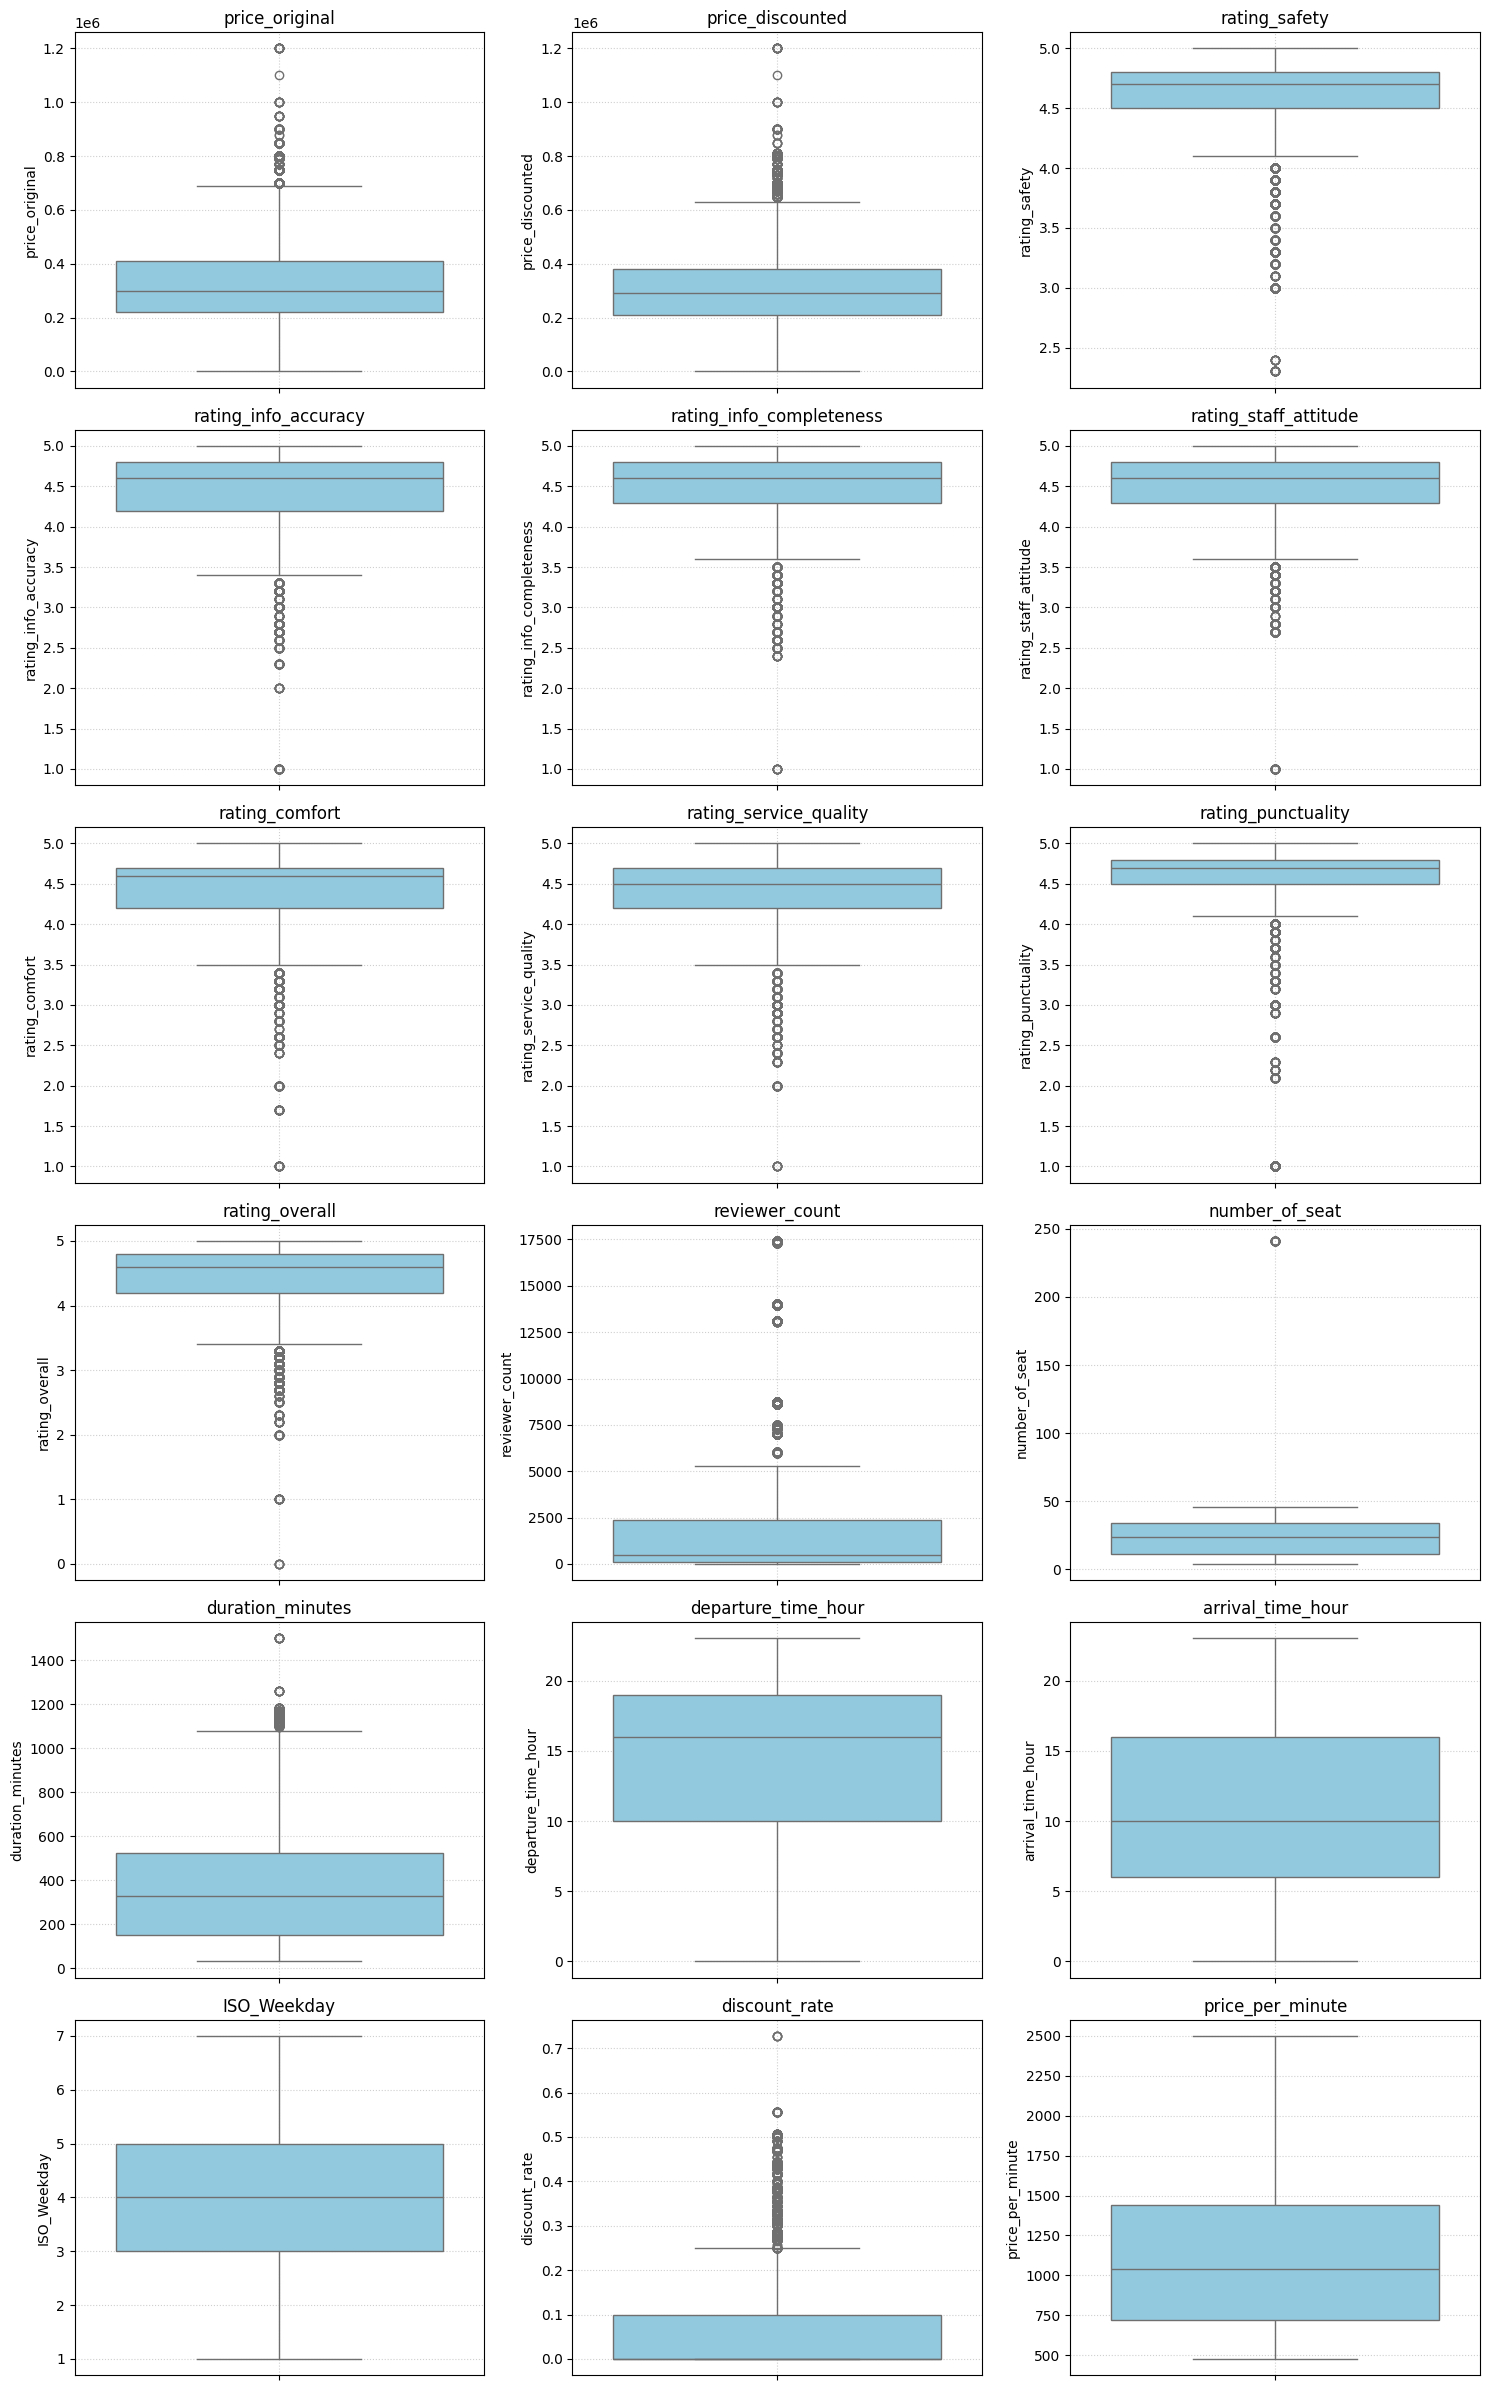

In [194]:
# Boxplots for all numeric columns in df
num_cols = df.select_dtypes(include='number').columns.tolist()
n = len(num_cols)
if n == 0:
    print("No numeric columns found in df.")
else:
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axes = axes.flatten()
    for ax, col in zip(axes, num_cols):
        sns.boxplot(y=df[col], ax=ax, color="skyblue")
        ax.set_title(col)
        ax.grid(True, linestyle=':', alpha=0.6)
    # hide any leftover axes
    for ax in axes[n:]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

In [195]:
def handle_outliers(df, col, lower_quantile=0.05, upper_quantile=0.95):
    # Chỉ áp dụng nếu cột là số thực
    if pd.api.types.is_numeric_dtype(df[col]):
        lower = df[col].quantile(lower_quantile)
        upper = df[col].quantile(upper_quantile)
        df[col] = df[col].clip(lower=lower, upper=upper)
    return df


In [196]:
# # Boxplots for all numeric columns in df
# num_cols = df.select_dtypes(include='number').columns.tolist()
# n = len(num_cols)
# if n == 0:
#     print("No numeric columns found in df.")
# else:
#     ncols = 3
#     nrows = (n + ncols - 1) // ncols
#     fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
#     axes = axes.flatten()
#     for ax, col in zip(axes, num_cols):
#         sns.boxplot(y=df[col], ax=ax, color="skyblue")
#         ax.set_title(col)
#         ax.grid(True, linestyle=':', alpha=0.6)
#     # hide any leftover axes
#     for ax in axes[n:]:
#         ax.set_visible(False)
#     plt.tight_layout()
#     plt.show()

---

In [197]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
price_original,23206.0,333291.217789,0.0,220000.0,300000.0,410000.0,1200000.0,158613.762383
price_discounted,23206.0,309107.129751,0.0,210000.0,290000.0,382500.0,1200000.0,148156.70352
departure_date,23206,2025-11-16 23:49:15.890717952,2025-11-12 00:00:00,2025-11-14 00:00:00,2025-11-17 00:00:00,2025-11-19 00:00:00,2025-11-21 00:00:00,NaN
rating_safety,23206.0,4.584056,2.3,4.5,4.7,4.8,5.0,0.362669
rating_info_accuracy,23206.0,4.450086,1.0,4.2,4.6,4.8,5.0,0.471081
rating_info_completeness,23206.0,4.510101,1.0,4.3,4.6,4.8,5.0,0.424047
rating_staff_attitude,23206.0,4.485125,1.0,4.3,4.6,4.8,5.0,0.430549
rating_comfort,23206.0,4.435719,1.0,4.2,4.6,4.7,5.0,0.465403
rating_service_quality,23206.0,4.401935,1.0,4.2,4.5,4.7,5.0,0.478436
rating_punctuality,23206.0,4.612234,1.0,4.5,4.7,4.8,5.0,0.467783


In [198]:
df["rating_quality"] = df[["rating_comfort","rating_service_quality","rating_staff_attitude"]].mean(axis=1)
df["rating_info"] = df[["rating_info_accuracy","rating_info_completeness"]].mean(axis=1)
df["value_index"] = df["rating_overall"] / df["price_discounted"]

In [199]:
features = [
    "price_discounted",
    "discount_rate",
    "price_per_minute",
    "value_index",
    "rating_overall",
    "rating_quality",
    "rating_info",
    "rating_safety",
    "rating_punctuality"
]

In [200]:
numeric_cols = df.select_dtypes(include=['number']).columns

for col in numeric_cols:
    df = handle_outliers(df, col)

In [201]:
# Kiểm tra NaN
print(df[features].isna().sum())

# Kiểm tra Inf
import numpy as np
print(np.isinf(df[features]).sum())

price_discounted        0
discount_rate         287
price_per_minute        0
value_index             0
rating_overall          0
rating_quality          0
rating_info             0
rating_safety           0
rating_punctuality      0
dtype: int64
price_discounted      0
discount_rate         0
price_per_minute      0
value_index           0
rating_overall        0
rating_quality        0
rating_info           0
rating_safety         0
rating_punctuality    0
dtype: int64


In [202]:
# Cách 1: điền giá trị trung bình hoặc median
df[features] = df[features].fillna(df[features].median())

# Cách 2: loại bỏ hàng chứa NaN/Inf
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=features)

In [203]:
from sklearn.cluster import KMeans 
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import RobustScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), features)           
    ])

X_processed = preprocessor.fit_transform(df)

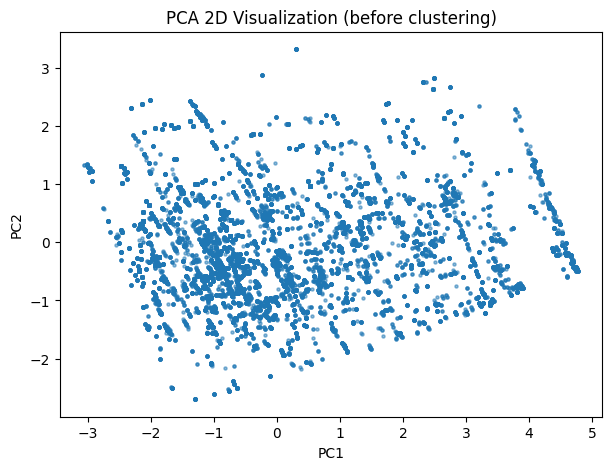

In [204]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=5, alpha=0.5)
plt.title("PCA 2D Visualization (before clustering)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [ ]:
print(pca.explained_variance_ratio_.sum())

0.6965979050049493


f:\Document\Tổng hợp các môn học\Đồ án DS\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


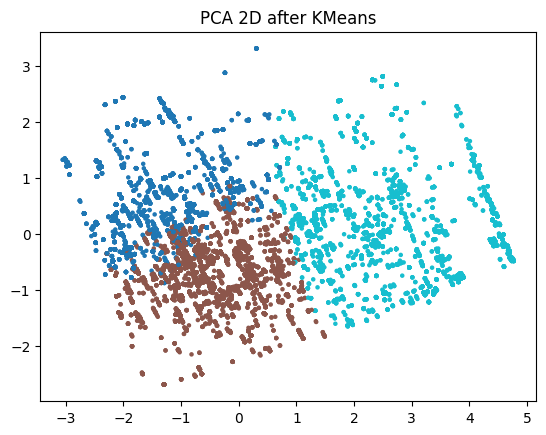

In [206]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_processed)

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="tab10", s=5)
plt.title("PCA 2D after KMeans")
plt.show()


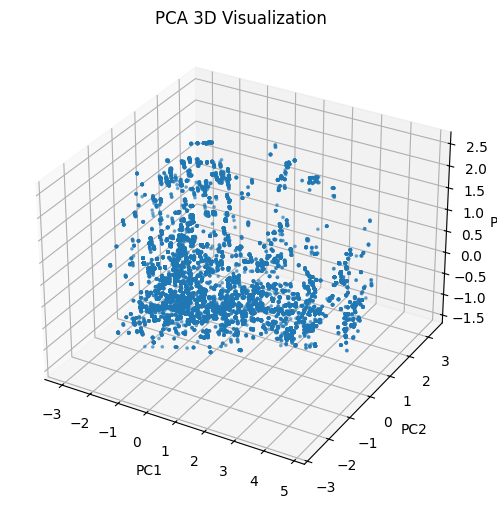

In [207]:
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_processed)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    X_pca3[:,0], 
    X_pca3[:,1],
    X_pca3[:,2], 
    s=3, alpha=0.5
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("PCA 3D Visualization")
plt.show()


f:\Document\Tổng hợp các môn học\Đồ án DS\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
f:\Document\Tổng hợp các môn học\Đồ án DS\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
f:\Document\Tổng hợp các môn học\Đồ án DS\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
f:\Document\Tổng hợp các môn học\Đồ án DS\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureW

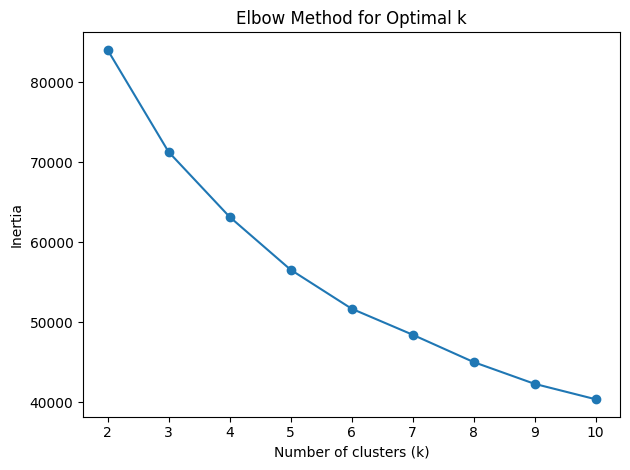

In [208]:
result = []
for i in range(2, 11):
    model = KMeans(n_clusters=i, random_state=42)
    model.fit(X_processed)
    result.append(model.inertia_)
plt.plot(range(2, 11), result, marker='o');
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

In [209]:
from sklearn.metrics import silhouette_score

result = []
for i in range(2, 6):

    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(X_processed)

    # Tính silhouette score
    score = silhouette_score(X_processed, labels)

    result.append([i, score])

for i, score in result:
    print(f'Number of clusters: {i}, Silhouette Score: {score:.4f}')

f:\Document\Tổng hợp các môn học\Đồ án DS\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
f:\Document\Tổng hợp các môn học\Đồ án DS\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
f:\Document\Tổng hợp các môn học\Đồ án DS\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
f:\Document\Tổng hợp các môn học\Đồ án DS\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureW

Number of clusters: 2, Silhouette Score: 0.3621
Number of clusters: 3, Silhouette Score: 0.2267
Number of clusters: 4, Silhouette Score: 0.2203
Number of clusters: 5, Silhouette Score: 0.2212


f:\Document\Tổng hợp các môn học\Đồ án DS\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'KMeans Clustering Results')

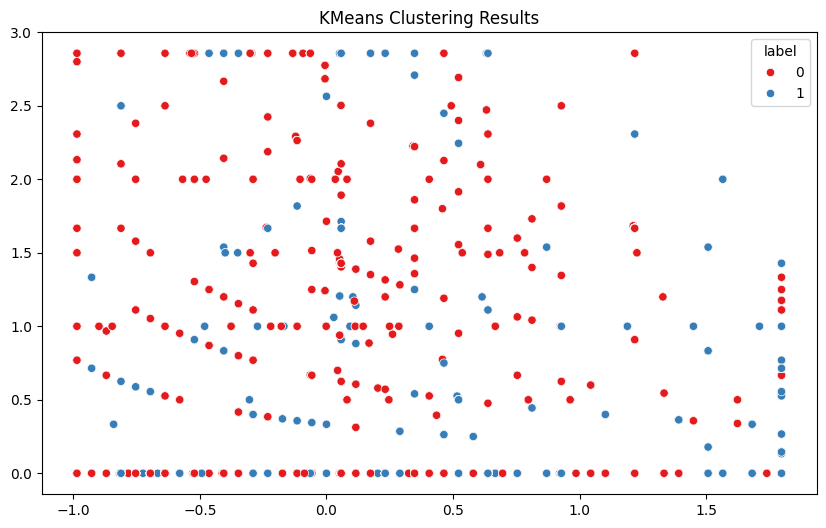

In [210]:
df['label'] = KMeans(n_clusters=2, random_state=42).fit_predict(X_processed)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_processed[:, 0], y=X_processed[:, 1], hue=df['label'], palette='Set1')
plt.title('KMeans Clustering Results') 

In [211]:
from sklearn.mixture import GaussianMixture
result = []
for i in range(2, 6):
    gmm = GaussianMixture(n_components=3, random_state=42)
    labels = gmm.fit_predict(X_processed)
    score = silhouette_score(X_processed, labels)

    result.append([i, score])

for i, score in result:
    print(f'Number of clusters: {i}, Silhouette Score: {score:.4f}')

Number of clusters: 2, Silhouette Score: 0.1598
Number of clusters: 3, Silhouette Score: 0.1598
Number of clusters: 4, Silhouette Score: 0.1598
Number of clusters: 5, Silhouette Score: 0.1598
